In [156]:
import open3d as o3d
import numpy as np
import math
import glob, os, re
import networkx as nx
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import itertools
from pyvis.network import Network
from collections import deque
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, MultiPolygon
from shapely.ops import unary_union
from shapely.affinity import translate
import trimesh


In [169]:
# mesh = trimesh.load('/home/aichi2204/Documents/bkl2go/20240412-library2/minimini_1/gt1_1.obj')


In [170]:
lines

["# Blender v3.0.1 OBJ File: ''\n",
 '# www.blender.org\n',
 'mtllib gt1_1.mtl\n',
 'o gt1_1\n',
 'v -73.748001 11.019000 0.036000\n',
 'v -72.526436 12.030313 0.151719\n',
 'v -72.513000 12.011000 0.170000\n',
 'v -72.291000 12.206000 0.187630\n',
 'v -68.901001 8.124000 0.241236\n',
 'v -69.161377 7.903985 0.230535\n',
 'v -69.025490 7.748147 0.241000\n',
 'v -67.395134 9.090528 0.319446\n',
 'v -66.256165 7.712245 0.327337\n',
 'v -66.392975 7.587253 0.371000\n',
 'v -62.567181 2.956474 0.742791\n',
 'v -62.263897 3.220000 0.759171\n',
 'v -67.372055 9.389579 1.072235\n',
 'v -68.199699 8.701752 1.047268\n',
 'v -71.585808 12.794614 0.981318\n',
 'v -69.762062 14.331565 1.022284\n',
 'l 1 2\n',
 'l 2 3\n',
 'l 3 4\n',
 'l 4 5\n',
 'l 5 6\n',
 'l 6 7\n',
 'l 7 8\n',
 'l 8 9\n',
 'l 9 10\n',
 'l 10 11\n',
 'l 11 12\n',
 'l 12 13\n',
 'l 13 14\n',
 'l 14 15\n',
 'l 15 16\n']

In [173]:
def obj2LineString(input_path):
    with open(input_path, 'r') as file:
        lines = file.readlines()

    # 頂点と辺のリストを初期化
    vertices = []
    edges = []

    # ファイルの各行を処理
    for line in lines:
        parts = line.split()
        if parts[0] == 'v':  # 頂点の処理
            vertices.append([float(parts[1]), float(parts[2]), float(parts[3])])
        elif parts[0] == 'l':  # 辺の処理
            edge = [int(index) - 1 for index in parts[1:]]  # OBJのインデックスは1から始まるため0に調整
            edges.extend([(edge[i], edge[i+1]) for i in range(len(edge)-1)])

    # NumPy配列に変換
    vertices = np.array(vertices)
    # 辺の配列に変換
    edges = np.array(edges)

    tmp = []
    for e in edges:
        tmp.append([[vertices[e[0],0],vertices[e[0],1]],
                    [vertices[e[1],0],vertices[e[1],1]]])

    return MultiLineString(tmp)

In [253]:
def heipke_evaluation(gt_line:LineString, ex_line:LineString, buffer_distance:float):
    gt_buffer = gt_line.buffer(buffer_distance)
    ex_buffer = ex_line.buffer(buffer_distance)

    # gt_buffer = unary_union(gt_buffer)

    TP = ex_line.intersection(gt_buffer).length
    FP = ex_line.length - TP
    TN = gt_line.intersection(ex_buffer).length
    FN = gt_line.length - TN
    # print(TP,FP,TN,FN)
    completeness = TP/(TP+FN)
    correctness = TP/(TP+FP)
    quality = TP/(TP+FP+FN)
    return np.array([TP,FP,TN,FN, completeness, correctness, quality])

In [302]:
data = []
for i in ([1,2,3,4]):
    gt_line = obj2LineString("/home/aichi2204/Documents/bkl2go/20240412-library2/minimini_1/gt{}.obj".format(i))
    ex_line = obj2LineString("/home/aichi2204/Documents/bkl2go/20240412-library2/minimini_1/ex{}.obj".format(i))
    res = heipke_evaluation(gt_line, ex_line,0.1)
    data.append(res)
data = np.array(data)
tp,fp,fn = np.mean(data, axis=0)[[0,1,3]]
print(tp/(tp+fn))
print(tp/(tp+fp))
print(tp/(tp+fp+fn))

0.9605780001781696
0.9914915978612051
0.9527245774561354


In [295]:
data[:,4:]

array([[0.85963608, 0.9489931 , 0.82167149],
       [1.        , 1.        , 1.        ],
       [0.96871896, 0.97292697, 0.94329165],
       [0.99737398, 1.        , 0.99737398]])

0.9033981411253299
0.9641515438216761
0.8740395354028387


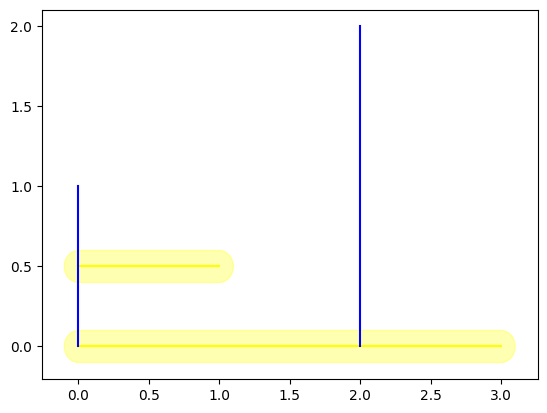

In [150]:
fig, ax = plt.subplots()
for line in gt_line.geoms:
    ax.plot(line.xy[0], line.xy[1], label='gt', color='yellow') 
for buffer in gt_buffer.geoms:
    ax.fill(buffer.exterior.xy[0], buffer.exterior.xy[1], alpha=0.3, label='Ground Truth Buffer', color='yellow')
# ax.fill(gt_buffer.exterior.xy[0], gt_buffer.exterior.xy[1], alpha=0.3, label='Ground Truth Buffer', color='blue')

# ax.plot(ex_line.xy[0], ex_line.xy[1], label='ex', color='blue')
for line in ex_line.geoms:
    ax.plot(line.xy[0], line.xy[1], label='ex', color='blue') 

In [115]:

# MultiLineStringの作成
l = MultiLineString([
    [[0, 0], [1, 0]], 
    [[1, 0], [2, 0]]
])

# バッファの作成
b = l.buffer(0.5)
line = LineString([[1, 0], [1, 1]])

In [116]:
# 交差部分を計算
intersection = b.intersection(line)

# 交差部分の長さを計算
intersection_length = intersection.length

print(f"交差部分の長さ: {intersection_length}")

交差部分の長さ: 0.5


In [124]:
print(intersection)

LINESTRING (1 0, 1 0.5)
